# KNN

In [1]:
#importing the required libraries
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import sqlite3
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
import nltk
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import StandardScaler
from scipy.linalg import eigh
import re
from gensim.models import word2vec
import pickle
from gensim.models import KeyedVectors
import string
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer
from gensim.models import Word2Vec
from sklearn import decomposition
pca = decomposition.PCA()
from sklearn.manifold import TSNE
from scipy.sparse import csc_matrix
from scipy.sparse import csr_matrix
from tqdm import tqdm
import string
from sklearn.cross_validation import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.cross_validation import cross_val_score
from collections import Counter
from sklearn.metrics import accuracy_score
from sklearn import cross_validation
from sklearn.model_selection import TimeSeriesSplit
from prettytable import PrettyTable
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import f1_score
from sklearn.metrics import roc_curve, auc
from sklearn.decomposition import TruncatedSVD
nltk.download('stopwords')

/usr/local/lib/python3.5/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
[nltk_data] Downloading package stopwords to
[nltk_data]     /home/gs12345iam/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [2]:
#loading the data through sqlite and preprocesing it a little bit.
temp = sqlite3.connect('database.sqlite')
temp = pd.read_sql_query("""SELECT * FROM Reviews WHERE SCORE != 3""", temp)
def partiton(x):
    if x > 3:
        return 'positive'
    else:
        return 'negative'
score = temp['Score']
positive_negative = score.map(partiton)
temp['Score'] = positive_negative

In [4]:
#sorting the data in ascending order according to the time stamp
temp.sort_values('Time', inplace=True)
temp.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
138706,150524,0006641040,ACITT7DI6IDDL,shari zychinski,0,0,positive,939340800,EVERY book is educational,this witty little book makes my son laugh at l...
138683,150501,0006641040,AJ46FKXOVC7NR,Nicholas A Mesiano,2,2,positive,940809600,This whole series is great way to spend time w...,I can remember seeing the show when it aired o...
417839,451856,B00004CXX9,AIUWLEQ1ADEG5,Elizabeth Medina,0,0,positive,944092800,Entertainingl Funny!,Beetlejuice is a well written movie ..... ever...
417859,451878,B00004CXX9,A344SMIA5JECGM,Vincent P. Ross,1,2,positive,944438400,A modern day fairy tale,"A twist of rumplestiskin captured on film, sta..."
212472,230285,B00004RYGX,A344SMIA5JECGM,Vincent P. Ross,1,2,positive,944438400,A modern day fairy tale,"A twist of rumplestiskin captured on film, sta..."


In [5]:
#getting rid of the duplicates
final = temp.drop_duplicates(subset={"UserId","ProfileName","Time","Text"}, keep='first', inplace=False)
final.shape

(364173, 10)

In [6]:
#Removing all the points where Denominator < Numerator
final = final[final.HelpfulnessNumerator <= final.HelpfulnessDenominator]
final.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
138706,150524,0006641040,ACITT7DI6IDDL,shari zychinski,0,0,positive,939340800,EVERY book is educational,this witty little book makes my son laugh at l...
138683,150501,0006641040,AJ46FKXOVC7NR,Nicholas A Mesiano,2,2,positive,940809600,This whole series is great way to spend time w...,I can remember seeing the show when it aired o...
417839,451856,B00004CXX9,AIUWLEQ1ADEG5,Elizabeth Medina,0,0,positive,944092800,Entertainingl Funny!,Beetlejuice is a well written movie ..... ever...
417859,451878,B00004CXX9,A344SMIA5JECGM,Vincent P. Ross,1,2,positive,944438400,A modern day fairy tale,"A twist of rumplestiskin captured on film, sta..."
417838,451855,B00004CXX9,AJH6LUC1UT1ON,The Phantom of the Opera,0,0,positive,946857600,FANTASTIC!,Beetlejuice is an excellent and funny movie. K...


In [7]:
final.shape

(364171, 10)

In [8]:
#Taking top 100k values for the assignment
final = final.iloc[0: 100000,:]

In [9]:
final.shape

(100000, 10)

# Text Preprocessing: Stemming, stop-word removal and Lemmatization.

In [2]:
stop = set(stopwords.words('english'))
sno = nltk.stem.SnowballStemmer('english')
def clean_html(sentence):
    clean = re.compile('<.*?>')
    cleantext = re.sub(clean, ' ', sentence)
    return cleantext
def clean_punctuation(sentence):
    cleaned = re.sub(r'[?|!|\'|"|#]',r'',sentence)
    cleaned = re.sub(r'[.|,|)|(|\|/]',r' ',cleaned)
    return cleaned

In [11]:
i=0
strl = ' '
final_string = []
all_positive_words = []
all_negative_words = []
s = ''
for sent in final['Text'].values:
    sent = clean_html(sent)
    filtered_sentence = []
    for w in sent.split():
        for cleaned_words in clean_punctuation(w).split():
            if ((cleaned_words.isalpha()) & (len(cleaned_words) > 2)):
                if (cleaned_words.lower() not in stop):
                    s=(sno.stem(cleaned_words.lower())).encode('utf8')
                    filtered_sentence.append(s)
                    if (final['Score'].values)[i] == 'positive': 
                        all_positive_words.append(s) 
                    if(final['Score'].values)[i] == 'negative':
                        all_negative_words.append(s) 
                else:
                    continue
            else:
                continue 
    str1 = b" ".join(filtered_sentence) 
    
    final_string.append(str1)
    i+=1

In [12]:
final['CleanedText']=final_string 
final['CleanedText']=final['CleanedText'].str.decode("utf-8")

In [13]:
final.head(3)
conn = sqlite3.connect('final.sqlite')
c=conn.cursor()
conn.text_factory = str
final.to_sql('Reviews', conn,  schema=None, if_exists='replace', index=True, index_label=None, chunksize=None, dtype=None)
final.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,CleanedText
138706,150524,0006641040,ACITT7DI6IDDL,shari zychinski,0,0,positive,939340800,EVERY book is educational,this witty little book makes my son laugh at l...,witti littl book make son laugh loud recit car...
138683,150501,0006641040,AJ46FKXOVC7NR,Nicholas A Mesiano,2,2,positive,940809600,This whole series is great way to spend time w...,I can remember seeing the show when it aired o...,rememb see show air televis year ago child sis...
417839,451856,B00004CXX9,AIUWLEQ1ADEG5,Elizabeth Medina,0,0,positive,944092800,Entertainingl Funny!,Beetlejuice is a well written movie ..... ever...,beetlejuic well written movi everyth excel act...
417859,451878,B00004CXX9,A344SMIA5JECGM,Vincent P. Ross,1,2,positive,944438400,A modern day fairy tale,"A twist of rumplestiskin captured on film, sta...",twist rumplestiskin captur film star michael k...
417838,451855,B00004CXX9,AJH6LUC1UT1ON,The Phantom of the Opera,0,0,positive,946857600,FANTASTIC!,Beetlejuice is an excellent and funny movie. K...,beetlejuic excel funni movi keaton hilari wack...


In [14]:
#Saving the cleaned data for future assignments
clean_data = open("clean_data_1.pickle", "wb")
pickle.dump(final, clean_data)
clean_data.close()

In [3]:
pickle_in = open("clean_data_1.pickle", "rb")
final = pickle.load(pickle_in)

In [4]:
final.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,CleanedText
138706,150524,0006641040,ACITT7DI6IDDL,shari zychinski,0,0,positive,939340800,EVERY book is educational,this witty little book makes my son laugh at l...,witti littl book make son laugh loud recit car...
138683,150501,0006641040,AJ46FKXOVC7NR,Nicholas A Mesiano,2,2,positive,940809600,This whole series is great way to spend time w...,I can remember seeing the show when it aired o...,rememb see show air televis year ago child sis...
417839,451856,B00004CXX9,AIUWLEQ1ADEG5,Elizabeth Medina,0,0,positive,944092800,Entertainingl Funny!,Beetlejuice is a well written movie ..... ever...,beetlejuic well written movi everyth excel act...
417859,451878,B00004CXX9,A344SMIA5JECGM,Vincent P. Ross,1,2,positive,944438400,A modern day fairy tale,"A twist of rumplestiskin captured on film, sta...",twist rumplestiskin captur film star michael k...
417838,451855,B00004CXX9,AJH6LUC1UT1ON,The Phantom of the Opera,0,0,positive,946857600,FANTASTIC!,Beetlejuice is an excellent and funny movie. K...,beetlejuic excel funni movi keaton hilari wack...


In [5]:
final.shape

(100000, 11)

In [6]:
#Saving the score values in a diffrent list and processing it for train, cv and test data
scores = final['Score'].get_values()
li = lambda x: 1 if x=='positive'  else 0
final_scores = []
for i in range(0,100000):
    final_scores.append(li(scores[i]))
final_scores = np.asarray(final_scores)
final_scores.shape

(100000,)

# Dividing the whole data into train, cross-validation and test sets

In [7]:
#train data
X_train = final[0: 60000]
Y_train = final_scores[0: 60000]
print(X_train.shape)
print(Y_train.shape)

(60000, 11)
(60000,)


In [8]:
#CV data
X_CV = final[60000: 80000]
Y_CV = final_scores[60000: 80000]
print(X_CV.shape)
print(Y_CV.shape)

(20000, 11)
(20000,)


In [9]:
#test data
X_test = final[80000: ]
Y_test = final_scores[80000: ]
print(X_test.shape)
print(Y_test.shape)

(20000, 11)
(20000,)


# BOW

In [10]:
count_vect = CountVectorizer(max_features=2000, min_df=50)
X_train_bow = count_vect.fit_transform(X_train['CleanedText'].values)
X_train_bow.shape

(60000, 2000)

In [11]:
train_bow = open("train_bow.pickle", "wb")
pickle.dump(X_train_bow, train_bow)
train_bow.close()

In [12]:
X_CV_bow = count_vect.transform(X_CV['CleanedText'].values)
X_CV_bow.shape

(20000, 2000)

In [13]:
CV_bow = open("CV_bow.pickle", "wb")
pickle.dump(X_CV_bow, CV_bow)
CV_bow.close()

In [14]:
X_test_bow = count_vect.transform(X_test['CleanedText'].values)
X_test_bow.shape

(20000, 2000)

In [15]:
test_bow = open("test_bow.pickle", "wb")
pickle.dump(X_test_bow, test_bow)
test_bow.close()

# KNN on BOW with Brute Force Algorithm

In [16]:
#to get cross validation error.
def cv_scores(x, y):
    li = list(range(0,20))
    neighbors = list(filter(lambda x: x%2 != 0,li))
    cv_scores = []
    for k in neighbors:
        knn = KNeighborsClassifier(n_neighbors=k, algorithm='brute')
        knn.fit(X_train_bow, Y_train)
        pred = knn.predict(x)
        f1 = f1_score(y, pred)
        cv_scores.append(f1)
    return cv_scores

In [17]:
cv_scores = cv_scores(X_CV_bow, Y_CV)

In [18]:
li = list(range(0,20))
neighbors = list(filter(lambda x: x%2 != 0,li))

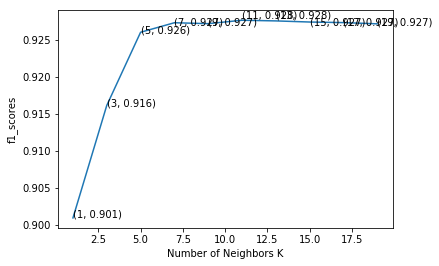

The f1 score for each k value is :  [0.901 0.916 0.926 0.927 0.927 0.928 0.928 0.927 0.927 0.927]


In [19]:
plt.plot(neighbors, cv_scores)

for xy in zip(neighbors, np.round(cv_scores,3)):
    plt.annotate('(%s, %s)' % xy, xy=xy, textcoords='data')

plt.xlabel('Number of Neighbors K')
plt.ylabel('f1_scores')
plt.show()

print("The f1 score for each k value is : ", np.round(cv_scores,3))

In [20]:
optimal_k = neighbors[cv_scores.index(max(cv_scores))]
print('\nThe optimal number of neighbors is %d.' % optimal_k)


The optimal number of neighbors is 11.


In [33]:
li = list(range(0,20))
neighbors = list(filter(lambda x: x%2 != 0,li))
train_errors = list()
CV_errors = list()
for k in neighbors:
    knn = KNeighborsClassifier(n_neighbors=k, algorithm='kd_tree')
    knn.fit(X_train_bow, Y_train)
    train_errors.append(knn.score(X_train_bow, Y_train))
    CV_errors.append(knn.score(X_CV_bow, Y_CV))

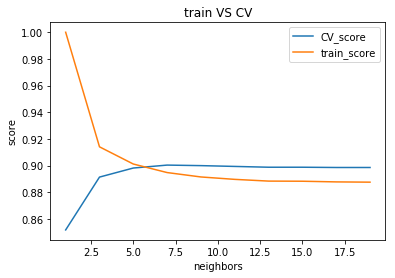

In [34]:
plt.plot(neighbors, CV_errors, label='CV_score')
plt.plot(neighbors, train_errors, label='train_score')
plt.title('train VS CV')
plt.ylabel('score')
plt.xlabel('neighbors')
plt.legend()
plt.show()

In [21]:
# instantiate learning model k = optimal_k
knn_optimal = KNeighborsClassifier(n_neighbors=optimal_k, algorithm='brute')

# fitting the model
knn_optimal.fit(X_train_bow, Y_train)

# predict the response
pred = knn_optimal.predict(X_test_bow)

# evaluate f1_score
f1_score = f1_score(Y_test, pred)

In [22]:
print('\nThe f1 score for test data for k = {} is {:2f}'.format(optimal_k, f1_score))


The f1 score for test data for k = 11 is 0.929632


In [23]:
conf_matrix = confusion_matrix(Y_test, pred)
conf_matrix

array([[  104,  2576],
       [   40, 17280]])

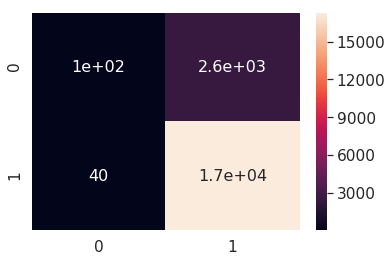

In [24]:
df_cm = pd.DataFrame(conf_matrix, range(2),
                  range(2))
#plt.figure(figsize = (10,7))
sns.set(font_scale=1.4)#for label size
sns.heatmap(df_cm, annot=True,annot_kws={"size": 16})# font size

In [25]:
print(classification_report(Y_test, pred))

             precision    recall  f1-score   support

          0       0.72      0.04      0.07      2680
          1       0.87      1.00      0.93     17320

avg / total       0.85      0.87      0.81     20000



# TF-IDF

In [16]:
tf_idf_vect = TfidfVectorizer(max_features=2000, min_df=50)
X_train_tfidf = tf_idf_vect.fit_transform(X_train['CleanedText'].values)
print("the type of count vectorizer ",type(X_train_tfidf))
print("the shape of out text TFIDF vectorizer ",X_train_tfidf.get_shape())
print("the number of unique words including both unigrams and bigrams ", X_train_tfidf.get_shape()[1])

the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text TFIDF vectorizer  (60000, 2000)
the number of unique words including both unigrams and bigrams  2000


In [17]:
train_tfidf = open("train_tfidf.pickle", "wb")
pickle.dump(X_train_tfidf, train_tfidf)
train_tfidf.close()

In [18]:
X_CV_tfidf = tf_idf_vect.transform(X_CV['CleanedText'].values)
print("the type of count vectorizer ",type(X_CV_tfidf))
print("the shape of out text TFIDF vectorizer ",X_CV_tfidf.get_shape())
print("the number of unique words including both unigrams and bigrams ", X_CV_tfidf.get_shape()[1])

the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text TFIDF vectorizer  (20000, 2000)
the number of unique words including both unigrams and bigrams  2000


In [19]:
CV_tfidf = open("CV_tfidf.pickle", "wb")
pickle.dump(X_CV_tfidf, CV_tfidf)
CV_tfidf.close()

In [20]:
X_test_tfidf = tf_idf_vect.transform(X_test['CleanedText'].values)
print("the type of count vectorizer ",type(X_test_tfidf))
print("the shape of out text TFIDF vectorizer ",X_test_tfidf.get_shape())
print("the number of unique words including both unigrams and bigrams ", X_test_tfidf.get_shape()[1])

the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text TFIDF vectorizer  (20000, 2000)
the number of unique words including both unigrams and bigrams  2000


In [21]:
test_tfidf = open("test_tfidf.pickle", "wb")
pickle.dump(X_test_tfidf, test_tfidf)
test_tfidf.close()

# KNN on TFIDF with Brute Force Algorithm

In [15]:
def tfidf_scores(x, y):
    li = list(range(0,20))
    neighbors = list(filter(lambda x: x%2 != 0,li))
    tfidf_scores = []
    for k in neighbors:
        knn = KNeighborsClassifier(n_neighbors=k, algorithm='brute')
        knn.fit(X_train_tfidf, Y_train)
        pred = knn.predict(x)
        f1 = f1_score(y, pred)
        tfidf_scores.append(f1)
    return tfidf_scores

In [16]:
tf_idf_scores = tfidf_scores(X_CV_tfidf, Y_CV)

In [17]:
li = list(range(0,20))
neighbors = list(filter(lambda x: x%2 != 0,li))

In [18]:
optimal_k = neighbors[tf_idf_scores.index(max(tf_idf_scores))]
print('\nThe optimal number of neighbors is %d.' % optimal_k)


The optimal number of neighbors is 13.


In [41]:
li = list(range(0,20))
neighbors = list(filter(lambda x: x%2 != 0,li))
train_errors = list()
CV_errors = list()
for k in neighbors:
    knn = KNeighborsClassifier(n_neighbors=k, algorithm='kd_tree')
    knn.fit(X_train_tfidf, Y_train)
    train_errors.append(knn.score(X_train_tfidf, Y_train))
    CV_errors.append(knn.score(X_CV_tfidf, Y_CV))

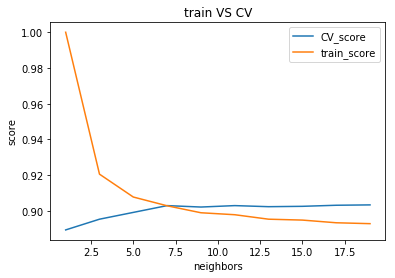

In [42]:
plt.plot(neighbors, CV_errors, label='CV_score')
plt.plot(neighbors, train_errors, label='train_score')
plt.title('train VS CV')
plt.ylabel('score')
plt.xlabel('neighbors')
plt.legend()
plt.show()

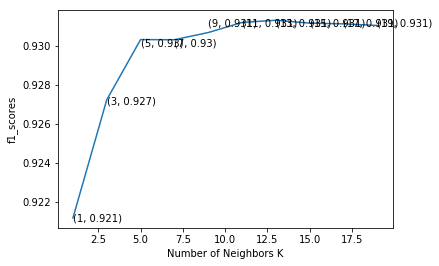

The f1 score for each k value is :  [0.921 0.927 0.93  0.93  0.931 0.931 0.931 0.931 0.931 0.931]


In [19]:
plt.plot(neighbors, tf_idf_scores)

for xy in zip(neighbors, np.round(tf_idf_scores,3)):
    plt.annotate('(%s, %s)' % xy, xy=xy, textcoords='data')

plt.xlabel('Number of Neighbors K')
plt.ylabel('f1_scores')
plt.show()

print("The f1 score for each k value is : ", np.round(tf_idf_scores,3))

In [20]:
# instantiate learning model k = optimal_k
knn_optimal = KNeighborsClassifier(n_neighbors=optimal_k, algorithm='brute')

# fitting the model
knn_optimal.fit(X_train_tfidf, Y_train)

# predict the response
pred = knn_optimal.predict(X_test_tfidf)

# evaluate f1_score
f1_score = f1_score(Y_test, pred)
print('\nThe f1 score for test data for k = {} is {:2f}'.format(optimal_k, f1_score))


The f1 score for test data for k = 13 is 0.932001


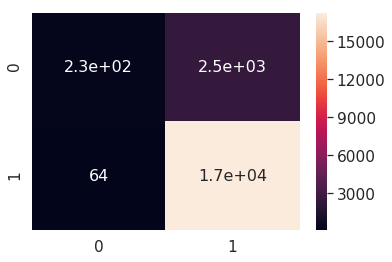

In [22]:
df_cm = pd.DataFrame(conf_matrix, range(2),
                  range(2))
#plt.figure(figsize = (10,7))
sns.set(font_scale=1.4)#for label size
sns.heatmap(df_cm, annot=True,annot_kws={"size": 16})# font size

In [23]:
print(classification_report(Y_test, pred))

             precision    recall  f1-score   support

          0       0.78      0.08      0.15      2680
          1       0.88      1.00      0.93     17320

avg / total       0.86      0.87      0.83     20000



# W2V

In [22]:
i=0
list_of_sent =[]
for sent in X_train['Text'].values:
    filtered_sentence =[]
    sent = clean_html(sent)
    for w in sent.split():
        for cleaned_words in clean_punctuation(w).split():
            if(cleaned_words.isalpha()):
                filtered_sentence.append(cleaned_words.lower())
            else:
                continue
    list_of_sent.append(filtered_sentence)


In [23]:
w2v_model=Word2Vec(list_of_sent, min_count=5 ,size=50)


In [24]:
w2v_words = list(w2v_model.wv.vocab)

# Average W2V

In [25]:
X_train_avgw2v = []; # the avg-w2v for each sentence/review is stored in this list
for sent in tqdm(list_of_sent): # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    X_train_avgw2v.append(sent_vec)
print(len(X_train_avgw2v))
print(len(X_train_avgw2v[0]))

100%|██████████| 60000/60000 [18:04<00:00, 55.32it/s]

60000
50


In [26]:
X_train_avgw2v = np.asarray(X_train_avgw2v)

In [27]:
X_train_avgw2v = StandardScaler().fit_transform(X_train_avgw2v)

In [28]:
train_w2v = open("train_w2v.pickle", "wb")
pickle.dump(X_train_avgw2v, train_w2v)
train_w2v.close()

In [29]:
i=0
list_of_sentence =[]
for sent in X_CV['Text'].values:
    filtered_sentence =[]
    sent = clean_html(sent)
    for w in sent.split():
        for cleaned_words in clean_punctuation(w).split():
            if(cleaned_words.isalpha()):
                filtered_sentence.append(cleaned_words.lower())
            else:
                continue
    list_of_sentence.append(filtered_sentence)

In [30]:
X_CV_avgw2v = []; # the avg-w2v for each sentence/review is stored in this list
for sent in tqdm(list_of_sentence): # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    X_CV_avgw2v.append(sent_vec)
print(len(X_CV_avgw2v))
print(len(X_CV_avgw2v[0]))

100%|██████████| 20000/20000 [06:29<00:00, 51.33it/s]

20000
50


In [31]:
X_CV_avgw2v = np.asarray(X_CV_avgw2v)
X_CV_avgw2v = StandardScaler().fit_transform(X_CV_avgw2v)
X_CV_avgw2v.shape

(20000, 50)

In [32]:
CV_w2v = open("CV_w2v.pickle", "wb")
pickle.dump(X_CV_avgw2v, CV_w2v)
CV_w2v.close()

In [33]:
i=0
list_of_sen =[]
for sent in X_test['Text'].values:
    filtered_sentence =[]
    sent = clean_html(sent)
    for w in sent.split():
        for cleaned_words in clean_punctuation(w).split():
            if(cleaned_words.isalpha()):
                filtered_sentence.append(cleaned_words.lower())
            else:
                continue
    list_of_sen.append(filtered_sentence)

In [34]:
X_test_avgw2v = []; # the avg-w2v for each sentence/review is stored in this list
for sent in tqdm(list_of_sen): # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    X_test_avgw2v.append(sent_vec)
print(len(X_test_avgw2v))
print(len(X_test_avgw2v[0]))

100%|██████████| 20000/20000 [06:23<00:00, 52.17it/s]

20000
50


In [35]:
X_test_avgw2v = np.asarray(X_test_avgw2v)
X_test_avgw2v = StandardScaler().fit_transform(X_test_avgw2v)
X_test_avgw2v.shape

(20000, 50)

In [36]:
test_w2v = open("test_w2v.pickle", "wb")
pickle.dump(X_test_avgw2v, test_w2v)
test_w2v.close()

# KNN on average W2V with Brute Force Algorithm

In [10]:
train_w2v = open("train_w2v.pickle", "rb")
X_train_avgw2v = pickle.load(train_w2v)

In [11]:
CV_w2v = open("CV_w2v.pickle", "rb")
X_CV_avgw2v = pickle.load(CV_w2v)

In [12]:
test_w2v = open("test_w2v.pickle", "rb")
X_test_avgw2v = pickle.load(test_w2v)

In [17]:
def w2v_scores(x, y):
    li = list(range(0,20))
    neighbors = list(filter(lambda x: x%2 != 0,li))
    w2v_scores = []
    for k in neighbors:
        knn = KNeighborsClassifier(n_neighbors=k, algorithm='brute')
        knn.fit(X_train_avgw2v, Y_train)
        pred = knn.predict(x)
        f1 = f1_score(y, pred)
        w2v_scores.append(f1)
    return w2v_scores

In [18]:
w2v_scores = w2v_scores(X_CV_avgw2v, Y_CV)

In [19]:
li = list(range(0,20))
neighbors = list(filter(lambda x: x%2 != 0,li))

In [20]:
optimal_k = neighbors[w2v_scores.index(max(w2v_scores))]
print('\nThe optimal number of neighbors is %d.' % optimal_k)


The optimal number of neighbors is 13.


In [60]:
li = list(range(0,20))
neighbors = list(filter(lambda x: x%2 != 0,li))
train_errors = list()
CV_errors = list()
for k in neighbors:
    knn = KNeighborsClassifier(n_neighbors=k, algorithm='kd_tree')
    knn.fit(X_train_avgw2v, Y_train)
    train_errors.append(knn.score(X_train_avgw2v, Y_train))
    CV_errors.append(knn.score(X_CV_avgw2v, Y_CV))

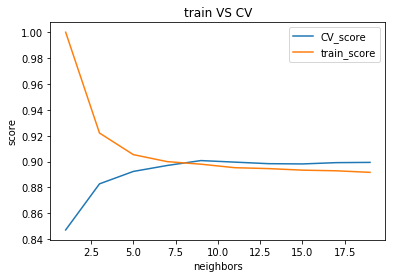

In [61]:
plt.plot(neighbors, CV_errors, label='CV_score')
plt.plot(neighbors, train_errors, label='train_score')
plt.title('train VS CV')
plt.ylabel('score')
plt.xlabel('neighbors')
plt.legend()
plt.show()

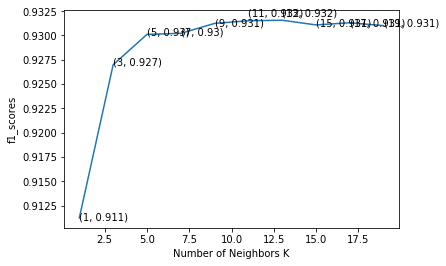

The f1 score for each k value is :  [0.911 0.927 0.93  0.93  0.931 0.932 0.932 0.931 0.931 0.931]


In [21]:
plt.plot(neighbors, w2v_scores)

for xy in zip(neighbors, np.round(w2v_scores,3)):
    plt.annotate('(%s, %s)' % xy, xy=xy, textcoords='data')

plt.xlabel('Number of Neighbors K')
plt.ylabel('f1_scores')
plt.show()

print("The f1 score for each k value is : ", np.round(w2v_scores,3))

In [22]:
# instantiate learning model k = optimal_k
knn_optimal = KNeighborsClassifier(n_neighbors=optimal_k, algorithm='brute')

# fitting the model
knn_optimal.fit(X_train_avgw2v, Y_train)

# predict the response
pred = knn_optimal.predict(X_test_avgw2v)

# evaluate f1_score
f1_score = f1_score(Y_test, pred)
print('\nThe f1 score for test data for k = {} is {:2f}'.format(optimal_k, f1_score))


The f1 score for test data for k = 13 is 0.933293


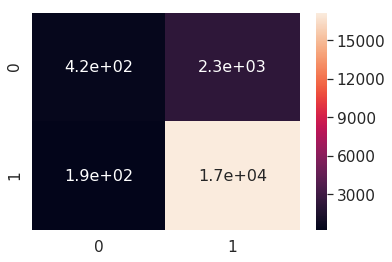

In [5]:
df_cm = pd.DataFrame(conf_matrix, range(2),
                  range(2))
#plt.figure(figsize = (10,7))
sns.set(font_scale=1.4)#for label size
sns.heatmap(df_cm, annot=True,annot_kws={"size": 16})# font size

In [24]:
conf_matrix = confusion_matrix(Y_test, pred)
conf_matrix

array([[  419,  2261],
       [  188, 17132]])

In [25]:
print(classification_report(Y_test, pred))

             precision    recall  f1-score   support

          0       0.69      0.16      0.25      2680
          1       0.88      0.99      0.93     17320

avg / total       0.86      0.88      0.84     20000



# TF-IDF W2V

In [22]:
i=0
list_of_sent =[]
for sent in X_train['CleanedText'].values:
    filtered_sentence =[]
    sent = clean_html(sent)
    for w in sent.split():
        for cleaned_words in clean_punctuation(w).split():
            if(cleaned_words.isalpha()):
                filtered_sentence.append(cleaned_words.lower())
            else:
                continue
    list_of_sent.append(filtered_sentence)


In [23]:
w2v_model=Word2Vec(list_of_sent, min_count=5 ,size=50)

In [24]:
w2v_words = list(w2v_model.wv.vocab)

In [25]:
model = TfidfVectorizer()
tf_idf_matrix = model.fit_transform(X_train['CleanedText'].values)
dictionary = dict(zip(model.get_feature_names(), list(model.idf_)))

In [26]:
tfidf_feat = model.get_feature_names()

X_train_tf = []
row=0;
for sent in tqdm(list_of_sent):  
    sent_vec = np.zeros(50) 
    weight_sum =0; 
    for word in sent: 
        if word in w2v_words:
            vec = w2v_model.wv[word]
            tf_idf = dictionary[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    X_train_tf.append(sent_vec)
    row += 1

100%|██████████| 60000/60000 [06:27<00:00, 154.71it/s]


In [27]:
X_train_tfidfw2v = np.asarray(X_train_tf)
X_train_tfidfw2v = StandardScaler().fit_transform(X_train_tfidfw2v)
X_train_tfidfw2v.shape

(60000, 50)

In [28]:
train_tfidfw2v = open("train_tfidfw2v.pickle", "wb")
pickle.dump(X_train_tfidfw2v, train_tfidfw2v)
train_tfidfw2v.close()

In [29]:
i=0
list_of_sentence =[]
for sent in X_CV['CleanedText'].values:
    filtered_sentence =[]
    sent = clean_html(sent)
    for w in sent.split():
        for cleaned_words in clean_punctuation(w).split():
            if(cleaned_words.isalpha()):
                filtered_sentence.append(cleaned_words.lower())
            else:
                continue
    list_of_sentence.append(filtered_sentence)


In [30]:
X_CV_tfidf = model.transform(X_CV['CleanedText'].values)


In [31]:
tfidf_feat = model.get_feature_names()

X_CV_tf = []
row=0;
for sent in tqdm(list_of_sentence):  
    sent_vec = np.zeros(50) 
    weight_sum =0; 
    for word in sent: 
        if word in w2v_words:
            vec = w2v_model.wv[word]
            tf_idf = dictionary[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    X_CV_tf.append(sent_vec)
    row += 1

100%|██████████| 20000/20000 [02:17<00:00, 157.36it/s]


In [32]:
X_CV_tfidfw2v = np.asarray(X_CV_tf)
X_CV_tfidfw2v = StandardScaler().fit_transform(X_CV_tfidfw2v)
X_CV_tfidfw2v.shape

(20000, 50)

In [33]:
CV_tfidfw2v = open("CV_tfidfw2v.pickle", "wb")
pickle.dump(X_CV_tfidfw2v, CV_tfidfw2v)
CV_tfidfw2v.close()

In [34]:
i=0
list_of_sen =[]
for sent in X_test['CleanedText'].values:
    filtered_sentence =[]
    sent = clean_html(sent)
    for w in sent.split():
        for cleaned_words in clean_punctuation(w).split():
            if(cleaned_words.isalpha()):
                filtered_sentence.append(cleaned_words.lower())
            else:
                continue
    list_of_sen.append(filtered_sentence)


In [35]:
X_test_tfidf = model.transform(X_test['CleanedText'].values)


In [36]:
tfidf_feat = model.get_feature_names()

X_test_tf = []
row=0;
for sent in tqdm(list_of_sen):  
    sent_vec = np.zeros(50) 
    weight_sum =0; 
    for word in sent: 
        if word in w2v_words:
            vec = w2v_model.wv[word]
            tf_idf = dictionary[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    X_test_tf.append(sent_vec)
    row += 1

100%|██████████| 20000/20000 [02:15<00:00, 114.86it/s]


In [37]:
X_test_tfidfw2v = np.asarray(X_test_tf)
X_test_tfidfw2v = StandardScaler().fit_transform(X_test_tfidfw2v)
X_test_tfidfw2v.shape

(20000, 50)

In [38]:
test_tfidfw2v = open("test_tfidfw2v.pickle", "wb")
pickle.dump(X_test_tfidfw2v, test_tfidfw2v)
test_tfidfw2v.close()

# KNN on TF-IDF W2V using Brute Force Algorithm

In [27]:
def tfidf_w2v_scores(x, y):
    li = list(range(0,20))
    neighbors = list(filter(lambda x: x%2 != 0,li))
    tfidf_w2v_scores = []
    for k in neighbors:
        knn = KNeighborsClassifier(n_neighbors=k, algorithm='brute')
        knn.fit(X_train_tfidfw2v, Y_train)
        pred = knn.predict(x)
        f1 = f1_score(y, pred)
        tfidf_w2v_scores.append(f1)
    return tfidf_w2v_scores

In [28]:
scores = tfidf_w2v_scores(X_CV_tfidfw2v, Y_CV)

In [29]:
li = list(range(0,20))
neighbors = list(filter(lambda x: x%2 != 0,li))

In [30]:
optimal_k = neighbors[scores.index(max(scores))]
print('\nThe optimal number of neighbors is %d.' % optimal_k)


The optimal number of neighbors is 15.


In [80]:
li = list(range(0,20))
neighbors = list(filter(lambda x: x%2 != 0,li))
train_errors = list()
CV_errors = list()
for k in neighbors:
    knn = KNeighborsClassifier(n_neighbors=k, algorithm='kd_tree')
    knn.fit(X_train_tfidfw2v, Y_train)
    train_errors.append(knn.score(X_train_tfidfw2v, Y_train))
    CV_errors.append(knn.score(X_CV_tfidfw2v, Y_CV))

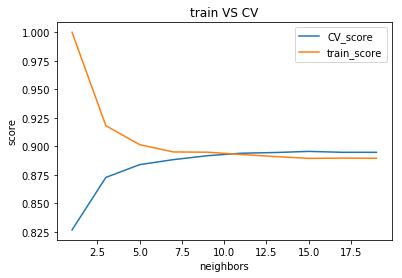

In [81]:
plt.plot(neighbors, CV_errors, label='CV_score')
plt.plot(neighbors, train_errors, label='train_score')
plt.title('train VS CV')
plt.ylabel('score')
plt.xlabel('neighbors')
plt.legend()
plt.show()

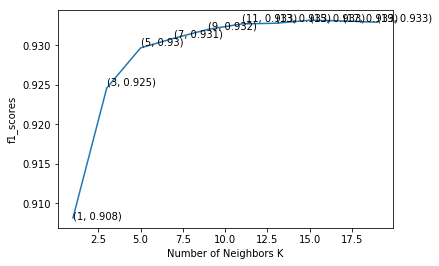

The f1 score for each k value is :  [0.908 0.925 0.93  0.931 0.932 0.933 0.933 0.933 0.933 0.933]


In [31]:
plt.plot(neighbors, scores)

for xy in zip(neighbors, np.round(scores,3)):
    plt.annotate('(%s, %s)' % xy, xy=xy, textcoords='data')

plt.xlabel('Number of Neighbors K')
plt.ylabel('f1_scores')
plt.show()

print("The f1 score for each k value is : ", np.round(scores,3))

In [32]:
# instantiate learning model k = optimal_k
knn_optimal = KNeighborsClassifier(n_neighbors=optimal_k, algorithm='brute')

# fitting the model
knn_optimal.fit(X_train_tfidfw2v, Y_train)

# predict the response
pred = knn_optimal.predict(X_test_tfidfw2v)

# evaluate f1_score
f1_score = f1_score(Y_test, pred)
print('\nThe f1 score for test data for k = {} is {:2f}'.format(optimal_k, f1_score))


The f1 score for test data for k = 15 is 0.933119


In [34]:
conf_matrix = confusion_matrix(Y_test, pred)
conf_matrix

array([[  403,  2277],
       [  180, 17140]])

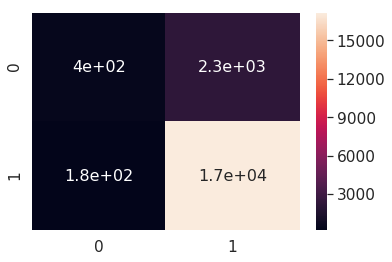

In [8]:
df_cm = pd.DataFrame(conf_matrix, range(2),
                  range(2))
#plt.figure(figsize = (10,7))
sns.set(font_scale=1.4)#for label size
sns.heatmap(df_cm, annot=True,annot_kws={"size": 16})# font size

In [35]:
print(classification_report(Y_test, pred))

             precision    recall  f1-score   support

          0       0.69      0.15      0.25      2680
          1       0.88      0.99      0.93     17320

avg / total       0.86      0.88      0.84     20000



# Analysis of KNN for BOW, TF-IDF, Average W2V and TF-IDF weighted W2V

In [9]:
x = PrettyTable()
x.field_names = ["Vectorizer", "Model", "Hyperparameter", "f1-Score on the test data"]
x.add_row(['BOW', 'Brute', 11, '0.9296'])
x.add_row(['TF-IDF', 'Brute', 13, '0.9320'])
x.add_row(['Average W2V', 'Brute', 13, '0.9332'])
x.add_row(['TF-IDF Weighted W2V', 'Brute', 15, '0.9331'])
print(x)

+---------------------+-------+----------------+---------------------------+
|      Vectorizer     | Model | Hyperparameter | f1-Score on the test data |
+---------------------+-------+----------------+---------------------------+
|         BOW         | Brute |       11       |           0.9296          |
|        TF-IDF       | Brute |       13       |           0.9320          |
|     Average W2V     | Brute |       13       |           0.9332          |
| TF-IDF Weighted W2V | Brute |       15       |           0.9331          |
+---------------------+-------+----------------+---------------------------+


#### Hence after looking at the model with various vectorizers I can say that the model with the Brute force algorithm works best with Average W2V although the diffrence in f1-scores for different vectorizers is minute.

# KNN with KD-TREE

### Preprocessing on BOW to make it a dense matrix

In [37]:
svd = TruncatedSVD(n_components=1999)
X_train_bow = svd.fit_transform(X_train_bow)

In [38]:
X_train_bow.shape

(60000, 1999)

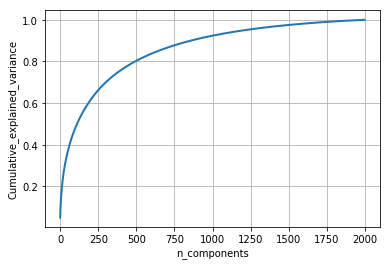

In [39]:
pca.n_components = 1999
pca_data = pca.fit_transform(X_train_bow)

percentage_var_explained = pca.explained_variance_ / np.sum(pca.explained_variance_);

cum_var_explained = np.cumsum(percentage_var_explained)

# Plot the PCA spectrum
plt.figure(1, figsize=(6, 4))

plt.clf()
plt.plot(cum_var_explained, linewidth=2)
plt.axis('tight')
plt.grid()
plt.xlabel('n_components')
plt.ylabel('Cumulative_explained_variance')
plt.show()

#### Reducing the number of components to to 200 because of computional expense and as around 50% of the variance is explained by 200 components.

In [40]:
svd = TruncatedSVD(n_components=200)
X_train_bow = svd.fit_transform(X_train_bow)

In [41]:
X_train_bow = pd.DataFrame(X_train_bow)

In [42]:
X_train_bow = np.asarray(X_train_bow)
X_train_bow.shape

(60000, 200)

In [43]:
train_truncatedbow = open("train_truncatedbow.pickle", "wb")
pickle.dump(X_train_bow, train_truncatedbow)
train_truncatedbow.close()

#### Similarly reducing the dimensions of CV and test set to 200 dimensions each.

In [44]:
svd = TruncatedSVD(n_components=200)
X_CV_bow = svd.fit_transform(X_CV_bow)

In [45]:
X_CV_bow = pd.DataFrame(X_CV_bow)
X_CV_bow = np.asarray(X_CV_bow)
X_CV_bow.shape

(20000, 200)

In [46]:
CV_truncatedbow = open("CV_truncatedbow.pickle", "wb")
pickle.dump(X_CV_bow, CV_truncatedbow)
CV_truncatedbow.close()

In [47]:
svd = TruncatedSVD(n_components=200)
X_test_bow = svd.fit_transform(X_test_bow)

In [48]:
X_test_bow = pd.DataFrame(X_test_bow)
X_test_bow = np.asarray(X_test_bow)
X_test_bow.shape

(20000, 200)

In [49]:
test_truncatedbow = open("test_truncatedbow.pickle", "wb")
pickle.dump(X_test_bow, test_truncatedbow)
test_truncatedbow.close()

# KNN on BOW with KD-TREE

In [29]:
def cv_scores(x, y):
    li = list(range(0,20))
    neighbors = list(filter(lambda x: x%2 != 0,li))
    cv_scores = []
    for k in tqdm(neighbors):
        knn = KNeighborsClassifier(n_neighbors=k, algorithm='kd_tree')
        knn.fit(X_train_bow, Y_train)
        pred = knn.predict(x)
        f1 = f1_score(y, pred)
        cv_scores.append(f1)
    return cv_scores

In [30]:
cv_scores = cv_scores(X_CV_bow, Y_CV)

100%|██████████| 10/10 [28:21<00:00, 169.72s/it]


In [31]:
li = list(range(0,20))
neighbors = list(filter(lambda x: x%2 != 0,li))

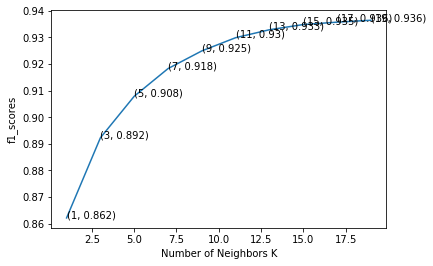

The f1 score for each k value is :  [0.862 0.892 0.908 0.918 0.925 0.93  0.933 0.935 0.936 0.936]


In [32]:
plt.plot(neighbors, cv_scores)

for xy in zip(neighbors, np.round(cv_scores,3)):
    plt.annotate('(%s, %s)' % xy, xy=xy, textcoords='data')

plt.xlabel('Number of Neighbors K')
plt.ylabel('f1_scores')
plt.show()

print("The f1 score for each k value is : ", np.round(cv_scores,3))

In [33]:
optimal_k = neighbors[cv_scores.index(max(cv_scores))]
print('\nThe optimal number of neighbors is %d.' % optimal_k)


The optimal number of neighbors is 19.


In [34]:
li = list(range(0,20))
neighbors = list(filter(lambda x: x%2 != 0,li))
train_errors = list()
CV_errors = list()
for k in tqdm(neighbors):
    knn = KNeighborsClassifier(n_neighbors=k, algorithm='kd_tree')
    knn.fit(X_train_bow, Y_train)
    train_errors.append(knn.score(X_train_bow, Y_train))
    CV_errors.append(knn.score(X_CV_bow, Y_CV))

100%|██████████| 10/10 [1:44:36<00:00, 659.41s/it]


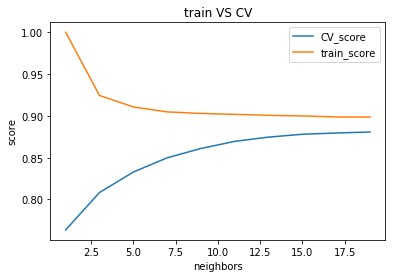

In [35]:
plt.plot(neighbors, CV_errors, label='CV_score')
plt.plot(neighbors, train_errors, label='train_score')
plt.title('train VS CV')
plt.ylabel('score')
plt.xlabel('neighbors')
plt.legend()
plt.show()

In [34]:
# instantiate learning model k = optimal_k
knn_optimal = KNeighborsClassifier(n_neighbors=optimal_k, algorithm='kd_tree')

# fitting the model
knn_optimal.fit(X_train_bow, Y_train)

# predict the response
pred = knn_optimal.predict(X_test_bow)

# evaluate f1_score
f1_score = f1_score(Y_test, pred)
print('\nThe f1 score for test data for k = {} is {:2f}'.format(optimal_k, f1_score))


The f1 score for test data for k = 19 is 0.925510


In [36]:
conf_matrix = confusion_matrix(Y_test, pred)
conf_matrix

array([[   29,  2651],
       [  118, 17202]])

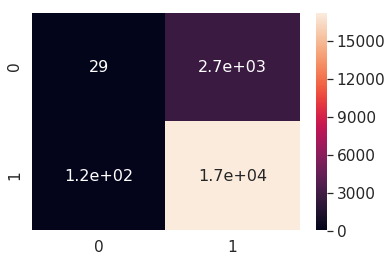

In [38]:
df_cm = pd.DataFrame(conf_matrix, range(2),
                  range(2))
#plt.figure(figsize = (10,7))
sns.set(font_scale=1.4)#for label size
sns.heatmap(df_cm, annot=True,annot_kws={"size": 16})# font size

In [37]:
print(classification_report(Y_test, pred))

             precision    recall  f1-score   support

          0       0.20      0.01      0.02      2680
          1       0.87      0.99      0.93     17320

avg / total       0.78      0.86      0.80     20000



### Preprocessing on TF-IDF to make it a dense matrix

In [50]:
svd = TruncatedSVD(n_components=1999)
X_train_tfidf = svd.fit_transform(X_train_tfidf)

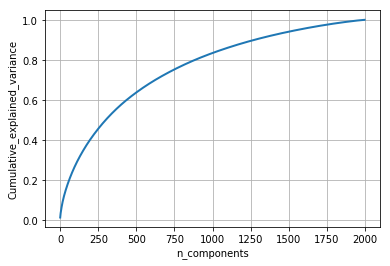

In [51]:
pca.n_components = 1999
pca_data = pca.fit_transform(X_train_tfidf)

percentage_var_explained = pca.explained_variance_ / np.sum(pca.explained_variance_);

cum_var_explained = np.cumsum(percentage_var_explained)

# Plot the PCA spectrum
plt.figure(1, figsize=(6, 4))

plt.clf()
plt.plot(cum_var_explained, linewidth=2)
plt.axis('tight')
plt.grid()
plt.xlabel('n_components')
plt.ylabel('Cumulative_explained_variance')
plt.show()

#### Reducing the number of components to to 275 because of computional expense and as around 50% of the variance is explained by 275 components.

In [52]:
svd = TruncatedSVD(n_components=275)
X_train_tfidf = svd.fit_transform(X_train_tfidf)

In [53]:
X_train_tfidf = np.asarray(X_train_tfidf)
X_train_tfidf.shape

(60000, 275)

In [54]:
train_truncatedtfidf = open("train_truncatedtfidf.pickle", "wb")
pickle.dump(X_train_tfidf, train_truncatedtfidf)
train_truncatedtfidf.close()

#### Similarly reducing the dimensions of CV and test set to 275 dimensions each.

In [55]:
svd = TruncatedSVD(n_components=275)
X_CV_tfidf = svd.fit_transform(X_CV_tfidf)

In [56]:
X_CV_tfidf = np.asarray(X_CV_tfidf)
X_CV_tfidf.shape

(20000, 275)

In [57]:
CV_truncatedtfidf = open("CV_truncatedtfidf.pickle", "wb")
pickle.dump(X_CV_tfidf, CV_truncatedtfidf)
CV_truncatedtfidf.close()

In [58]:
svd = TruncatedSVD(n_components=275)
X_test_tfidf = svd.fit_transform(X_test_tfidf)

In [59]:
X_test_tfidf = np.asarray(X_test_tfidf)
X_test_tfidf.shape

(20000, 275)

In [60]:
test_truncatedtfidf = open("test_truncatedtfidf.pickle", "wb")
pickle.dump(X_test_tfidf, test_truncatedtfidf)
test_truncatedtfidf.close()

## KNN on TF-IDF with KD-TREE algorithm

In [24]:
def tfidf_scores(x, y):
    li = list(range(0,20))
    neighbors = list(filter(lambda x: x%2 != 0,li))
    cv_scores = []
    for k in tqdm(neighbors):
        knn = KNeighborsClassifier(n_neighbors=k, algorithm='kd_tree')
        knn.fit(X_train_tfidf, Y_train)
        pred = knn.predict(x)
        f1 = f1_score(y, pred)
        cv_scores.append(f1)
    return cv_scores

In [25]:
tfidf_scores = tfidf_scores(X_CV_tfidf, Y_CV)

100%|██████████| 10/10 [37:30<00:00, 225.42s/it]


In [28]:
li = list(range(0,20))
neighbors = list(filter(lambda x: x%2 != 0,li))

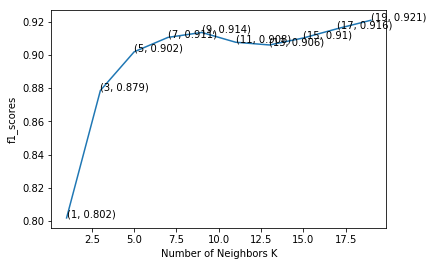

The f1 score for each k value is :  [0.802 0.879 0.902 0.911 0.914 0.908 0.906 0.91  0.916 0.921]


In [29]:
plt.plot(neighbors, tfidf_scores)

for xy in zip(neighbors, np.round(tfidf_scores,3)):
    plt.annotate('(%s, %s)' % xy, xy=xy, textcoords='data')

plt.xlabel('Number of Neighbors K')
plt.ylabel('f1_scores')
plt.show()

print("The f1 score for each k value is : ", np.round(tfidf_scores,3))

In [30]:
optimal_k = neighbors[tfidf_scores.index(max(tfidf_scores))]
print('\nThe optimal number of neighbors is %d.' % optimal_k)


The optimal number of neighbors is 19.


In [31]:
li = list(range(0,20))
neighbors = list(filter(lambda x: x%2 != 0,li))
train_errors = list()
CV_errors = list()
for k in tqdm(neighbors):
    knn = KNeighborsClassifier(n_neighbors=k, algorithm='kd_tree')
    knn.fit(X_train_tfidf, Y_train)
    train_errors.append(knn.score(X_train_tfidf, Y_train))
    CV_errors.append(knn.score(X_CV_tfidf, Y_CV))

100%|██████████| 10/10 [00:21<00:00,  2.23s/it]


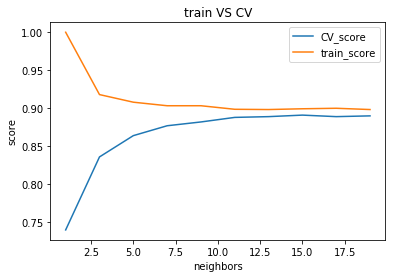

In [32]:
plt.plot(neighbors, CV_errors, label='CV_score')
plt.plot(neighbors, train_errors, label='train_score')
plt.title('train VS CV')
plt.ylabel('score')
plt.xlabel('neighbors')
plt.legend()
plt.show()

In [23]:
knn_optimal = KNeighborsClassifier(n_neighbors=optimal_k, algorithm='kd_tree')

# fitting the model
knn_optimal.fit(X_train_tfidfw2v, Y_train)

# predict the response
pred = knn_optimal.predict(X_test_tfidfw2v)

# evaluate f1_score
f1_score = f1_score(Y_test, pred)
print('\nThe f1 score for test data for k = {} is {:2f}'.format(optimal_k, f1_score))


The f1 score for test data for k = 19 is 0.919535


In [24]:
conf_matrix = confusion_matrix(Y_test, pred)
conf_matrix

array([[  50, 1166],
       [ 316, 8468]])

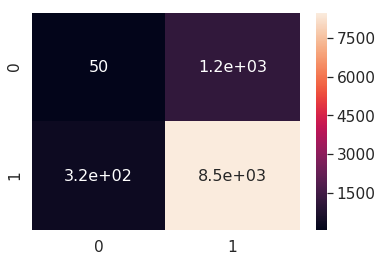

In [26]:
df_cm = pd.DataFrame(conf_matrix, range(2),
                  range(2))
#plt.figure(figsize = (10,7))
sns.set(font_scale=1.4)#for label size
sns.heatmap(df_cm, annot=True,annot_kws={"size": 16})# font size

In [25]:
print(classification_report(Y_test, pred))

             precision    recall  f1-score   support

          0       0.14      0.04      0.06      1216
          1       0.88      0.96      0.92      8784

avg / total       0.79      0.85      0.82     10000



## KNN on Average W2V

In [25]:
def w2v_scores(x, y):
    li = list(range(0,10))
    neighbors = list(filter(lambda x: x%2 != 0,li))
    cv_scores = []
    for k in tqdm(neighbors):
        knn = KNeighborsClassifier(n_neighbors=k, algorithm='kd_tree')
        knn.fit(X_train_avgw2v, Y_train)
        pred = knn.predict(x)
        f1 = f1_score(y, pred)
        cv_scores.append(f1)
    return cv_scores

In [26]:
w2v_scores = w2v_scores(X_CV_avgw2v, Y_CV)

100%|██████████| 5/5 [14:38<00:00, 175.47s/it]


In [27]:
li = list(range(0,10))
neighbors = list(filter(lambda x: x%2 != 0,li))

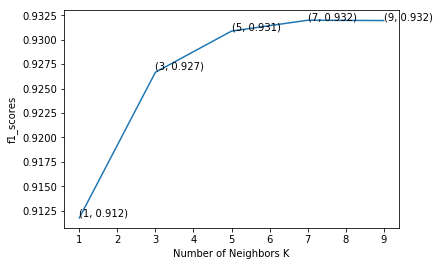

The f1 score for each k value is :  [0.912 0.927 0.931 0.932 0.932]


In [28]:
plt.plot(neighbors, w2v_scores)

for xy in zip(neighbors, np.round(w2v_scores,3)):
    plt.annotate('(%s, %s)' % xy, xy=xy, textcoords='data')

plt.xlabel('Number of Neighbors K')
plt.ylabel('f1_scores')
plt.show()

print("The f1 score for each k value is : ", np.round(w2v_scores,3))

In [29]:
optimal_k = neighbors[w2v_scores.index(max(w2v_scores))]
print('\nThe optimal number of neighbors is %d.' % optimal_k)


The optimal number of neighbors is 7.


In [32]:
li = list(range(0,10))
neighbors = list(filter(lambda x: x%2 != 0,li))
train_errors = list()
CV_errors = list()
for k in tqdm(neighbors):
    knn = KNeighborsClassifier(n_neighbors=k, algorithm='kd_tree')
    knn.fit(X_train_avgw2v, Y_train)
    train_errors.append(knn.score(X_train_avgw2v, Y_train))
    CV_errors.append(knn.score(X_CV_avgw2v, Y_CV))

100%|██████████| 5/5 [49:18<00:00, 572.32s/it]


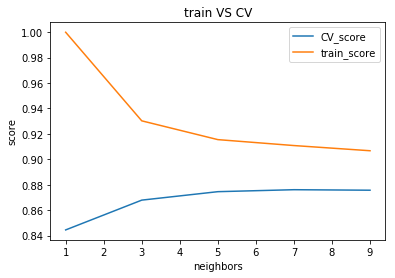

In [39]:
plt.plot(neighbors, CV_errors, label='CV_score')
plt.plot(neighbors, train_errors, label='train_score')
plt.title('train VS CV')
plt.ylabel('score')
plt.xlabel('neighbors')
plt.legend()
plt.show()



In [35]:
knn_optimal = KNeighborsClassifier(n_neighbors=optimal_k, algorithm='kd_tree')

# fitting the model
knn_optimal.fit(X_train_avgw2v, Y_train)

# predict the response
pred = knn_optimal.predict(X_test_avgw2v)

# evaluate f1_score
f1_score = f1_score(Y_test, pred)
print('\nThe f1 score for test data for k = {} is {:2f}'.format(optimal_k, f1_score))


The f1 score for test data for k = 7 is 0.932252


In [40]:
conf_matrix = confusion_matrix(Y_test, pred)
conf_matrix

array([[  512,  2168],
       [  305, 17015]])

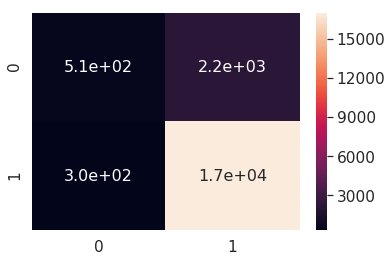

In [43]:
df_cm = pd.DataFrame(conf_matrix, range(2),
                  range(2))
#plt.figure(figsize = (10,7))
sns.set(font_scale=1.4)#for label size
sns.heatmap(df_cm, annot=True,annot_kws={"size": 16})# font size

In [38]:
print(classification_report(Y_test, pred))

             precision    recall  f1-score   support

          0       0.63      0.19      0.29      2680
          1       0.89      0.98      0.93     17320

avg / total       0.85      0.88      0.85     20000



## KNN on TF-IDF W2V

In [39]:
def tfidf_scores(x, y):
    li = list(range(0,10))
    neighbors = list(filter(lambda x: x%2 != 0,li))
    cv_scores = []
    for k in tqdm(neighbors):
        knn = KNeighborsClassifier(n_neighbors=k, algorithm='kd_tree')
        knn.fit(X_train_tfidfw2v, Y_train)
        pred = knn.predict(x)
        f1 = f1_score(y, pred)
        cv_scores.append(f1)
    return cv_scores

In [40]:
tfidf_scores = tfidf_scores(X_CV_tfidfw2v, Y_CV)

100%|██████████| 5/5 [14:33<00:00, 174.47s/it]


In [41]:
li = list(range(0,10))
neighbors = list(filter(lambda x: x%2 != 0,li))

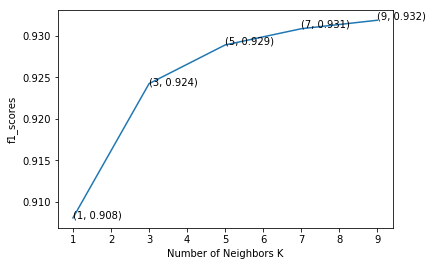

The f1 score for each k value is :  [0.908 0.924 0.929 0.931 0.932]


In [42]:
plt.plot(neighbors, tfidf_scores)

for xy in zip(neighbors, np.round(tfidf_scores,3)):
    plt.annotate('(%s, %s)' % xy, xy=xy, textcoords='data')

plt.xlabel('Number of Neighbors K')
plt.ylabel('f1_scores')
plt.show()

print("The f1 score for each k value is : ", np.round(tfidf_scores,3))

In [44]:
optimal_k = neighbors[tfidf_scores.index(max(tfidf_scores))]
print('\nThe optimal number of neighbors is %d.' % optimal_k)


The optimal number of neighbors is 9.


In [45]:
li = list(range(0,10))
neighbors = list(filter(lambda x: x%2 != 0,li))
train_errors = list()
CV_errors = list()
for k in tqdm(neighbors):
    knn = KNeighborsClassifier(n_neighbors=k, algorithm='kd_tree')
    knn.fit(X_train_tfidfw2v, Y_train)
    train_errors.append(knn.score(X_train_tfidfw2v, Y_train))
    CV_errors.append(knn.score(X_CV_tfidfw2v, Y_CV))

100%|██████████| 5/5 [49:43<00:00, 589.83s/it]


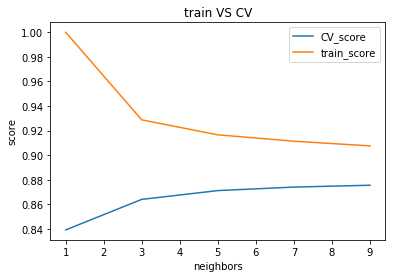

In [46]:
plt.plot(neighbors, CV_errors, label='CV_score')
plt.plot(neighbors, train_errors, label='train_score')
plt.title('train VS CV')
plt.ylabel('score')
plt.xlabel('neighbors')
plt.legend()
plt.show()

In [47]:
knn_optimal = KNeighborsClassifier(n_neighbors=optimal_k, algorithm='kd_tree')

# fitting the model
knn_optimal.fit(X_train_tfidfw2v, Y_train)

# predict the response
pred = knn_optimal.predict(X_test_tfidfw2v)

# evaluate f1_score
f1_score = f1_score(Y_test, pred)
print('\nThe f1 score for test data for k = {} is {:2f}'.format(optimal_k, f1_score))


The f1 score for test data for k = 9 is 0.932955


In [48]:
conf_matrix = confusion_matrix(Y_test, pred)
conf_matrix

array([[  464,  2216],
       [  239, 17081]])

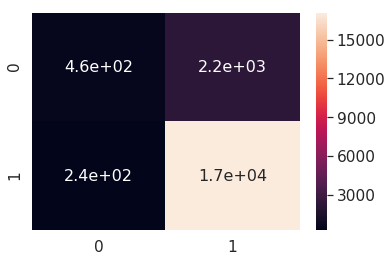

In [49]:
df_cm = pd.DataFrame(conf_matrix, range(2),
                  range(2))
#plt.figure(figsize = (10,7))
sns.set(font_scale=1.4)#for label size
sns.heatmap(df_cm, annot=True,annot_kws={"size": 16})# font size

In [50]:
print(classification_report(Y_test, pred))

             precision    recall  f1-score   support

          0       0.66      0.17      0.27      2680
          1       0.89      0.99      0.93     17320

avg / total       0.85      0.88      0.84     20000



## Analysis of KNN for KD-TREE Algorthmn with different vectorizers

In [51]:
x = PrettyTable()
x.field_names = ["Vectorizer", "Model", "Hyperparameter", "f1-Score on the test data"]
x.add_row(['BOW', 'KD-TREE', 19, '0.9255'])
x.add_row(['TF-IDF', 'KD-TREE', 19, '0.9195'])
x.add_row(['Average W2V', 'KD-TREE', 7, '0.9322'])
x.add_row(['TF-IDF Weighted W2V', 'KD-TREE', 9, '0.9329'])
print(x)

+---------------------+---------+----------------+---------------------------+
|      Vectorizer     |  Model  | Hyperparameter | f1-Score on the test data |
+---------------------+---------+----------------+---------------------------+
|         BOW         | KD-TREE |       19       |           0.9255          |
|        TF-IDF       | KD-TREE |       19       |           0.9195          |
|     Average W2V     | KD-TREE |       7        |           0.9322          |
| TF-IDF Weighted W2V | KD-TREE |       9        |           0.9329          |
+---------------------+---------+----------------+---------------------------+


#### Unlike the Brute force algorithm where average w2v model performed better here in the case of KD-TREE TF-IDF weighted w2v model is the best although the diffrence is still very minute